<p style="font-family: 'Courier New', Courier, monospace; font-size: 40px; font-weight: bold; color: blue;  text-align: center;">
  LoRaWAN Path Loss Measurements in an Indoor Setting: DATA SORTING
</p>

###  Notebook Summary 
This Notebook processes unsorted measurement data by:
- Converting and validating time data.
- Aggregating daily counts and visualizing the data.
- Extracting and analyzing unique gateway IDs.
- Filtering data for a specific gateways.
- Deduplicating data based on time and frame count differences.

###  1. Import Libraries and Load Data

This cell imports the required libraries and loads the dataset from a CSV file. It then prints basic information about the DataFrame.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('../all_data_files/unsorted_combined_measurements_data.csv', low_memory=False)
# Parse and filter by date range on 'time' column
# -----------------------------------------------------------
df['time'] = pd.to_datetime(df['time'], errors='coerce', utc=True)
df = df.dropna(subset=['time'])

start_utc = pd.Timestamp('2024-10-01', tz='UTC')
end_utc   = pd.Timestamp('2025-10-01', tz='UTC')  # exclusive end => keeps through 2025-09-30

df = df.loc[(df['time'] >= start_utc) & (df['time'] < end_utc)].copy()
# sanity check
print("\nTime window (UTC):", start_utc, "to", end_utc, "(exclusive end)")
print("Min time in df:", df['time'].min(), "| Max time in df:", df['time'].max())
# -----------------------------------------------------------

print("\nInitial DataFrame Info:")
df.info()


Time window (UTC): 2024-10-01 00:00:00+00:00 to 2025-10-01 00:00:00+00:00 (exclusive end)
Min time in df: 2024-10-01 00:00:07.374717+00:00 | Max time in df: 2025-09-30 23:59:55.971870+00:00

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 3255325 entries, 49294 to 3304620
Data columns (total 94 columns):
 #   Column                                                   Dtype              
---  ------                                                   -----              
 0   correlation_ids_0                                        object             
 1   device_id                                                object             
 2   end_device_ids_application_ids_application_id            object             
 3   end_device_ids_dev_addr                                  object             
 4   end_device_ids_dev_eui                                   object             
 5   end_device_ids_device_id                                 object             
 6   end_device_

### 2. Preprocess Time Data

Convert the 'time' column to datetime (with UTC) and remove invalid entries. Then, extract the date for daily aggregation and plot the unsorted data counts per day.

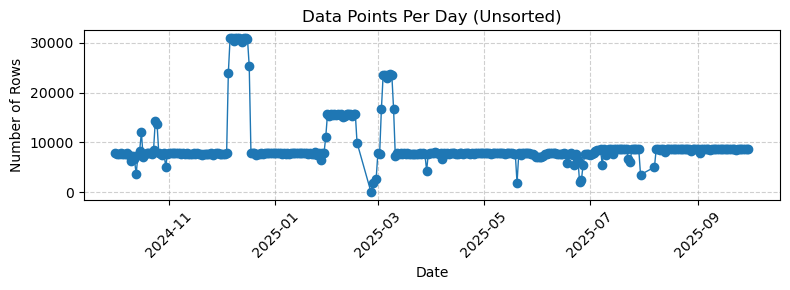

In [2]:
# Create a working copy and convert 'time' to datetime
df = df.copy()
df['time'] = pd.to_datetime(df['time'].astype(str), errors='coerce', utc=True)

# Report and drop rows with invalid datetime values
invalid_times = df[df['time'].isna()]
if not invalid_times.empty:
    print(f"Found {len(invalid_times)} invalid time rows; dropping them.")
df = df.dropna(subset=['time'])

# Extract date for aggregation
df['date'] = df['time'].dt.date

# Plot daily counts (unsorted data)
daily_counts_unsorted = df.groupby('date').size()
plt.figure(figsize=(8, 3))
daily_counts_unsorted.plot(kind='line', marker='o', linestyle='-', linewidth=1)
plt.title('Data Points Per Day (Unsorted)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 3. Unique Gateway Analysis

Extract unique gateway IDs from metadata columns (e.g., `uplink_message_rx_metadata_0_gateway_ids_gateway_id`), display their count, list them, and compute the number of rows associated with each gateway.


In [3]:
# Gateway summary w/ ID, EUI, and row count per gateway
gateway_id_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_gateway_id' for i in range(4)]
gateway_eui_cols = [f'uplink_message_rx_metadata_{i}_gateway_ids_eui' for i in range(4)]

gateway_euis = {}
for id_col, eui_col in zip(gateway_id_cols, gateway_eui_cols):
    if id_col not in df.columns:
        continue
    eui_series = df[eui_col] if eui_col in df.columns else pd.Series([pd.NA] * len(df), index=df.index)
    for gw, eui in zip(df[id_col], eui_series):
        if pd.isna(gw):
            continue
        gateway_euis.setdefault(gw, set()).add(eui)

gateway_counts = {}
for gw in gateway_euis:
    mask = pd.Series(False, index=df.index)
    for col in gateway_id_cols:
        if col in df.columns:
            mask |= df[col] == gw
    gateway_counts[gw] = int(mask.sum())

summary = []
for gw in sorted(gateway_euis):
    eui_list = ", ".join(sorted(str(e) for e in gateway_euis[gw] if pd.notna(e))) or "N/A"
    summary.append({
        "gateway_id": gw,
        "gateway_euis": eui_list,
        "row_count": gateway_counts.get(gw, 0),
    })

print(pd.DataFrame(summary))

             gateway_id      gateway_euis  row_count
0      a84041fdfe275e82  A84041FDFE275E82         32
1  eui-a84041ffff22dea4  A84041FFFF22DEA4     361489
2  eui-a84041ffff22def8  A84041FFFF22DEF8    2036881
3      kerlink-istation  7076FF005606004B         15
4            kerlink001  7276FF0039090946    3217141


### 4. Uplink-Level Deduplication (device + frame count, before gateway sorting)

Deduplicate using only end-device + uplink frame count within a 2-second window. This removes repeated receptions before any per-gateway sorting.


Original shape: (3255325, 97)
After uplink-level dedup: (2694528, 95)
Rows removed: 560797


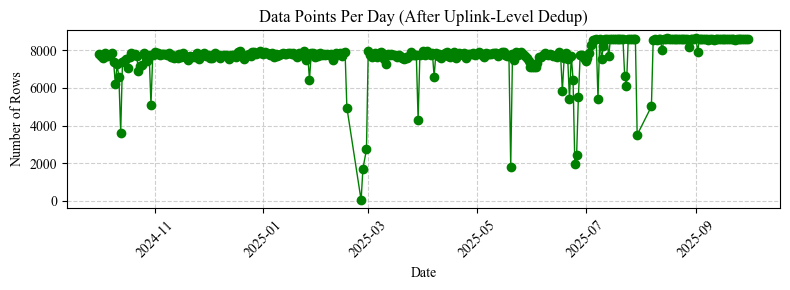

In [4]:
# Base for uplink-level dedup
df_uplink = df.copy()
df_uplink['time'] = pd.to_datetime(df_uplink['time'], errors='coerce', utc=True)
df_uplink = df_uplink.dropna(subset=['time'])

# Sort and compute deltas per device
df_uplink = df_uplink.sort_values(['end_device_ids_device_id', 'time']).copy()
g_up = df_uplink.groupby('end_device_ids_device_id', sort=False)
df_uplink['dt'] = g_up['time'].diff().dt.total_seconds()
df_uplink['f_cnt_diff'] = g_up['uplink_message_f_cnt'].diff()

# Flag duplicates: same f_cnt within [0, 2) seconds for the same device
uplink_dup = (df_uplink['f_cnt_diff'] == 0) & (df_uplink['dt'] >= 0) & (df_uplink['dt'] < 2)

df_uplink_dedup = (
    df_uplink.loc[~uplink_dup]
    .drop(columns=['dt', 'f_cnt_diff'], errors='ignore')
    .reset_index(drop=True)
)

print("Original shape:", df_uplink.shape)
print("After uplink-level dedup:", df_uplink_dedup.shape)
print("Rows removed:", df_uplink.shape[0] - df_uplink_dedup.shape[0])

# Daily counts after uplink dedup
df_uplink_dedup['date'] = df_uplink_dedup['time'].dt.date
daily_counts_uplink = df_uplink_dedup.groupby('date').size()
plt.figure(figsize=(8, 3))
daily_counts_uplink.plot(kind='line', marker='o', linestyle='-', linewidth=1, color='green')
plt.title('Data Points Per Day (After Uplink-Level Dedup)')
plt.xlabel('Date')
plt.ylabel('Number of Rows')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### 5. Filter & Sort Per Target Gateway (after uplink dedup)

Use the deduplicated uplink data, select target gateways, and sort per gateway/device/time for reporting.


Rows per gateway (overlaps counted) after uplink dedup:
 kerlink001              2663653
eui-a84041ffff22def8    1647908
eui-a84041ffff22dea4     283715
dtype: int64
Rows with N matching gateways (post-dedup): {1: 1048383, 2: 1391542, 3: 254603}
Shape after uplink dedup -> per-gateway sorting: (4595276, 96)


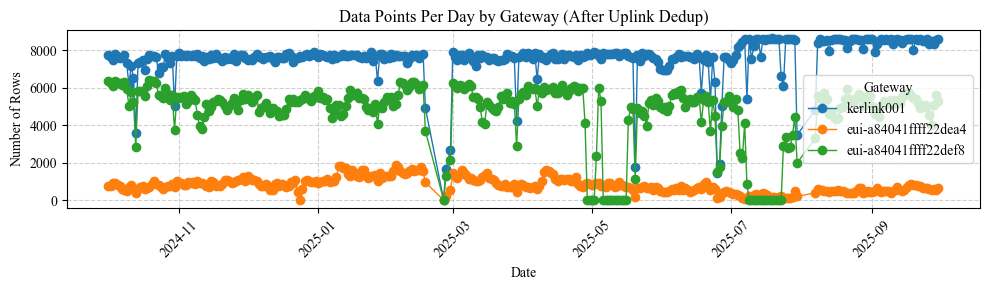

In [5]:
target_gateways = ["kerlink001", "eui-a84041ffff22dea4", "eui-a84041ffff22def8"]

# Any-column hit per gateway on the deduped data
hit_matrix = pd.DataFrame({gw: df_uplink_dedup[gateway_cols].eq(gw).any(axis=1) for gw in target_gateways})

per_gw_counts = hit_matrix.sum().sort_values(ascending=False)
print("Rows per gateway (overlaps counted) after uplink dedup:\n", per_gw_counts)

overlap_sizes = hit_matrix.sum(axis=1).value_counts().sort_index()
print("Rows with N matching gateways (post-dedup):", overlap_sizes.to_dict())

per_gw_frames = []
daily_by_gw = {}

for gw in target_gateways:
    sub = df_uplink_dedup.loc[hit_matrix[gw]].copy()
    sub['gateway_id'] = gw
    sub['time'] = pd.to_datetime(sub['time'], errors='coerce', utc=True)
    sub = sub.dropna(subset=['time']).sort_values(['gateway_id', 'end_device_ids_device_id', 'time'])
    sub['date'] = sub['time'].dt.date
    per_gw_frames.append(sub)
    daily_by_gw[gw] = sub.groupby('date').size()

df_dedup_by_gw = pd.concat(per_gw_frames, ignore_index=True)
print("Shape after uplink dedup -> per-gateway sorting:", df_dedup_by_gw.shape)

daily_df = pd.DataFrame(daily_by_gw).fillna(0)
plt.figure(figsize=(10, 3))
for gw in daily_df.columns:
    plt.plot(daily_df.index, daily_df[gw], marker="o", linewidth=1, label=gw)
plt.title("Data Points Per Day by Gateway (After Uplink Dedup)")
plt.xlabel("Date")
plt.ylabel("Number of Rows")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Gateway")
plt.tight_layout()
plt.show()

### 6. Post-Dedup Sanity Check

Confirm no residual duplicates per gateway (same device/frame count within 2s) remain after uplink-level deduplication and gateway sorting.


In [6]:
chk = df_dedup_by_gw.sort_values(['gateway_id', 'end_device_ids_device_id', 'time']).copy()
g2 = chk.groupby(['gateway_id', 'end_device_ids_device_id'], sort=False)
chk['dt_check'] = g2['time'].diff().dt.total_seconds()
chk['f_cnt_diff_check'] = g2['uplink_message_f_cnt'].diff()
resid_dups = ((chk['f_cnt_diff_check'] == 0) & (chk['dt_check'] >= 0) & (chk['dt_check'] < 2)).sum()
print("Residual duplicates after uplink-level dedup (<2s, same f_cnt):", resid_dups)

df_dedup_final = chk.drop(columns=['dt_check', 'f_cnt_diff_check'], errors='ignore').reset_index(drop=True)

Residual duplicates after uplink-level dedup (<2s, same f_cnt): 0


### 7. Save Cleaned Data and Preview

Save the cleaned, deduplicated dataset to a CSV file and display the last 10 rows as a preview.

In [7]:
# Save the cleaned data to CSV
df_dedup_final.to_csv('../LoRaWAN Localization - Advanced Files/all3_gateways_combined_measurements_data.csv', index=False)
print("Data cleaning and deduplication completed. CSV file saved.")

# Display the tail of the deduplicated DataFrame
df_dedup_final.tail(10)

Data cleaning and deduplication completed. CSV file saved.


,correlation_ids_0,device_id,end_device_ids_application_ids_application_id,end_device_ids_dev_addr,end_device_ids_dev_eui,end_device_ids_device_id,end_device_ids_join_eui,received_at,time,uplink_message_confirmed,...,uplink_message_settings_frequency,uplink_message_settings_time,uplink_message_settings_timestamp,uplink_message_version_ids_band_id,uplink_message_version_ids_brand_id,uplink_message_version_ids_firmware_version,uplink_message_version_ids_hardware_version,uplink_message_version_ids_model_id,date,gateway_id
4595266,gs:uplink:01JJRVY5D7HRC56E69HJNR1BAJ,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:07:57.944410062Z,2025-01-29 11:07:57.971066+00:00,True,...,868500000,2025-01-29T11:07:57.675045Z,3.211643e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595267,gs:uplink:01JJRW0G2RXG9M7MTBY4TNVRZ5,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:09:14.405190448Z,2025-01-29 11:09:14.433548+00:00,True,...,867900000,2025-01-29T11:09:14.142329Z,3.288110e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595268,gs:uplink:01JJRW3NEC152Y4RH68WMK5JQN,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:10:58.203436452Z,2025-01-29 11:10:58.231703+00:00,True,...,868100000,2025-01-29T11:10:57.957262Z,3.391925e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595269,gs:uplink:01JJRW6042AY1EC1JCAPWG36KY,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:14.686310289Z,2025-01-29 11:12:14.714619+00:00,True,...,867500000,2025-01-29T11:12:14.423554Z,3.468392e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595270,gs:uplink:01JJRW78WMJDKKJ3ARVFR473R9,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:12:56.423484950Z,2025-01-29 11:12:56.450676+00:00,True,...,868500000,2025-01-29T11:12:56.173194Z,3.510141e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595271,gs:uplink:01JJRW93HHYTCP1G6DEB524JPX,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:13:56.483298039Z,2025-01-29 11:13:56.511742+00:00,True,...,867900000,2025-01-29T11:13:56.225962Z,3.570194e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595272,gs:uplink:01JJRWAXN566DRPYZ0EVXK1944,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:14:55.986247587Z,2025-01-29 11:14:56.014379+00:00,True,...,868300000,2025-01-29T11:14:55.747108Z,3.629715e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595273,gs:uplink:01JJRWCRA1CNF45JY7F8RQSGWK,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:15:56.045457219Z,2025-01-29 11:15:56.074514+00:00,True,...,867900000,2025-01-29T11:15:55.802812Z,3.689771e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595274,gs:uplink:01JJRWEJYSJVH43SGSPYDY3K60,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:16:56.105283552Z,2025-01-29 11:16:56.132382+00:00,True,...,867500000,2025-01-29T11:16:55.859469Z,3.749827e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
4595275,gs:uplink:01JJRWGDKHQN7BP9CMK1FSKVE2,up,pilot-test,260BBBD6,A8610A32303B7219,pilotdevice06,0,2025-01-29T11:17:56.162296967Z,2025-01-29 11:17:56.189602+00:00,True,...,867100000,2025-01-29T11:17:55.916136Z,3.809884e+09,EU_863_870,arduino,1.2.3,1.0,mkr-wan-1310,2025-01-29,kerlink001
